# 7.1 Assessing the impacts of interventions

In Tutorial 5.2 you saw how to add interventions to the model. In this tutorial you will expand on this idea by comparing the impact of two different interventions for a model of measles.

## Problem 1

First, define a treatment intervention that can be given to people as soon as they start to exhibit symptoms (i.e., as soon as they are infected). For people who receive the treatment, their mean duration of infection will be 5 days.

Next, define a 'quarantine' intervention where people who have been exposed are told to quarantine (i.e. stay home). People who are in quarantine will no longer be transmissible.

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.06 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.39 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.57 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.74 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.06 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.34 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.61 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.83 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.07 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.34 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.57 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.82 s)  •••••••••••••••••••• 100%



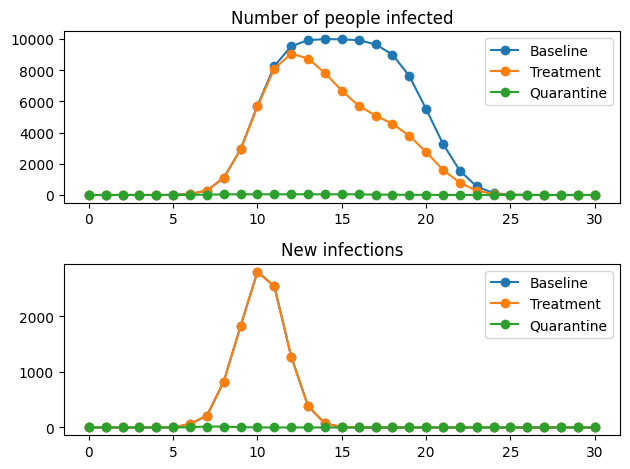

Number of infections averted by treatment: 29922.0
Number of infections averted by quarantine: 104570.0
Percentage of infections averted by treatment: 0.28484392700410294
Percentage of infections averted by quarantine: 0.9954591754167182


In [5]:
import numpy as np # Math
import sciris as sc # Utilities
import pylab as pl # Plotting
import starsim as ss # ABM


class Treatment(ss.Intervention):  # Create a new, generic treatment intervention

    def __init__(self, prob=0.5, mean_dur_infection=5):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of vaccination
        self.dur_infection = ss.normal(mean_dur_infection, 1)  # Store the duration of infection

    def apply(self, sim):
        measles = sim.diseases.measles

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[measles.ti_infected == sim.ti]  # People are eligible for treatment if they have just started exhibiting symptoms
        n_eligible = len(eligible_ids) # Number of people who are eligible

        # Define who receives treatment
        is_treated = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
        treat_ids = eligible_ids[is_treated]  # Pull out the IDs for the people receiving the treatment

        # Treated people will have a new disease progression
        dur_inf = self.dur_infection.rvs(treat_ids)  # Sample duration of infection by generating random variables (RVS) drawn from the distribution of durations

        # Determine who dies and who recovers and when
        will_die = measles.pars.p_death.rvs(treat_ids)  # Sample probability of dying
        dead_uids = treat_ids[will_die]  # Pull out the IDs of people who die
        recover_uids = treat_ids[~will_die]  # Pull out the IDs of people who recovery
        measles.ti_dead[dead_uids] = measles.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt  # Set the time of death
        measles.ti_recovered[recover_uids] = measles.ti_infected[recover_uids] + dur_inf[~will_die] / sim.dt  # Set the time of recovery


class Quarantine(ss.Intervention):
    def __init__(self, prob=1, rel_trans=0, delay=0):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of quarantining
        self.rel_trans = rel_trans  # Relative transmissibility of people in quarantine
        self.delay = delay  # Delay between exposure and being put into quarantine

    def apply(self, sim):
        measles = sim.diseases.measles

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[(measles.ti_exposed - self.delay) == sim.ti]  # People are eligible for quarantine after a delay 
        n_eligible = len(eligible_ids)  # Number of eligible people

        # Define who is quarantined
        in_quarantine = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people are quarantined by comparing np.random.rand() to self.p
        quar_ids = eligible_ids[in_quarantine]  # Pull out the IDs for the people going into quarantine

        # Quarantined people will have a reduced relative transmissibility
        measles.rel_trans[quar_ids] = self.rel_trans


def make_run_sim(delay=0, n_contacts=4, beta=0.9):

    # Make the interventions
    treatment = Treatment()  # Create the specific treatment
    quarantine = Quarantine(delay=delay)  # Create the specific quarantine

    # Make the parameters
    pars = dict(start=0, end=30, dt=1.0)  # Define the parameters of the simulation
    n_contacts = n_contacts  # Define the daily number of contacts that a person has
    beta = beta  # Define the probability of an infected person transmitting to a susceptible person

    # In tutorial 5.2, the 'pars' dictionary also oncluded the diseases and the network. It looked like this:
    #    pars = dict(start=0, end=50, dt=1.0, diseases='sis', networks='random')
    # In this tutorial, we will see how to change some of the parameters of the disease and network
    # Rather than putting them in the pars dictionary, we provide them separately to the simulation. 

    # Define "baseline" and "intervention" sims: without any interventions, with treatment, and with quarantine
    baseline = ss.Sim(
        pars, 
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.Measles(pars=dict(beta=beta))
        )
    treat_sim = ss.Sim(
        pars, 
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.Measles(pars=dict(beta=beta)),
        interventions=treatment
        )
    quar_sim = ss.Sim(
        pars,
        networks=ss.RandomNet(pars=dict(n_contacts=ss.poisson(n_contacts))),
        diseases = ss.Measles(pars=dict(beta=beta)),
        interventions=quarantine
        )

    # Run the three simulations
    baseline.run()
    treat_sim.run()
    quar_sim.run()

    # Pull out results to plot
    tvec = baseline.yearvec
    n_inf_base = baseline.results.measles.n_infected
    n_inf_treat = treat_sim.results.measles.n_infected
    n_inf_quar = quar_sim.results.measles.n_infected

    new_inf_base = baseline.results.measles.new_infections
    new_inf_treat = treat_sim.results.measles.new_infections
    new_inf_quar = quar_sim.results.measles.new_infections

    # Create the figure
    pl.figure()

    # Plot number of people infected
    pl.subplot(2,1,1)  # Create the first panel in the plot
    pl.title('Number of people infected')
    pl.plot(tvec, n_inf_base, 'o-', label='Baseline')  # Plot baseline
    pl.plot(tvec, n_inf_treat, 'o-', label='Treatment')  # Plot treatment
    pl.plot(tvec, n_inf_quar, 'o-', label='Quarantine')  # Plot quarantine
    pl.legend()

    # Plot number of new infections
    pl.subplot(2,1,2) # Create the second panel in the plot
    pl.title('New infections')
    pl.plot(tvec, new_inf_base, 'o-', label='Baseline') # Plot baseline
    pl.plot(tvec, new_inf_treat, 'o-', label='Treatment') # Plot treatment
    pl.plot(tvec, new_inf_quar, 'o-', label='Quarantine') # Plot quarantine
    pl.legend()

    sc.figlayout()
    pl.show()

    # Calculate and display the number of infections averted
    averted_by_treatment = n_inf_base.sum() - n_inf_treat.sum()
    averted_by_quarantine = n_inf_base.sum() - n_inf_quar.sum()
    print(f'Number of infections averted by treatment: {averted_by_treatment}')
    print(f'Number of infections averted by quarantine: {averted_by_quarantine}')
    print(f'Percentage of infections averted by treatment: {(averted_by_treatment)/n_inf_base.sum()}')
    print(f'Percentage of infections averted by quarantine: {(averted_by_quarantine)/n_inf_base.sum()}')


# Make, run, and plot the simulation
make_run_sim()


## Problem 2

Explore the properties of the interventions:

- People are put into quarantine with a delay (`delay`). Try running the intervention with `delay = 1` and interpret your result.
- What recommendation would you make to the goverment about the treatment vs the quarantine policy?

## Solution 2

### Explore the properties of the interventions

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.09 s)  ———————————————————— 3%
  Running 10.0 (10/31) (1.14 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (1.30 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (1.47 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.30 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.45 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.66 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.25 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.40 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.82 s)  •••••••••••••••••••• 100%



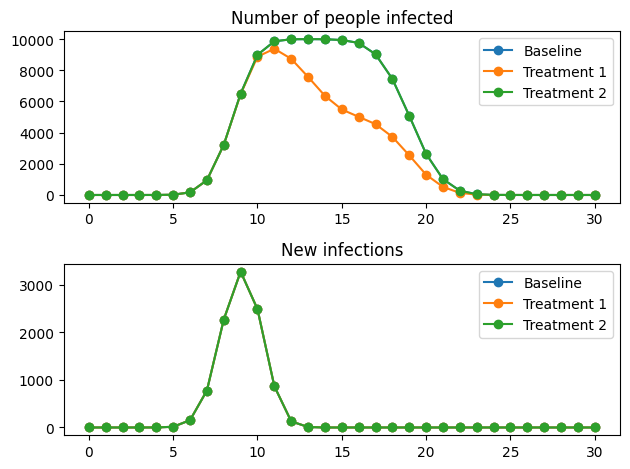

Averted by treatment: 29871.0
Averted by quarantine: 0.0


In [4]:
make_run_sim(delay=1)